In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

In [2]:
def check_missing_data(df: pd.DataFrame) -> None:
    """
    Check the entire dataset for missing values
    """
    found = False
    for _, column in enumerate(df):
        if df[column].isnull().any():
            found = True
            print(f"{column} number on missing values is {df[column].isnull().sum()}")

    if not(found):
        print("There are no missing values in the dataset!")

def change_values(df, column, final_val, is_column_name = True, condition = lambda x: pd.isnull(x), transformations = lambda x: x):
    """
    Change the values in a given column based on some condition. New value can be given or derived from some other column.
    Transformations can be applied to the values from other columns.
    """
    for i, elem in enumerate(df[column]):
        if condition(elem):
            df.loc[i, column] = (transformations(df.loc[i, final_val]) if is_column_name else final_val)


In [3]:
shots1 = pd.read_csv('datasets/joined_shots_2013.csv')
shots2 = pd.read_csv('datasets/joined_shots_2014.csv')

shots = pd.concat([shots1, shots2], ignore_index=True)
shots.head()

,Unnamed: 0,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,DRIBBLES,FGM,FINAL_MARGIN,GAME_CLOCK,GAME_ID,GAME_ID.1,...,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,0,"Turner, Evan",202323.0,1.9,17.0,0.0,10.0,8:09,21300165,21300165,...,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6.0,-40.0,53.0,1.0,0.0
1,1,"Turner, Evan",202323.0,3.2,0.0,1.0,10.0,9:10,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26.0,182.0,195.0,1.0,1.0
2,2,"Carter-Williams, Michael",203487.0,3.5,0.0,0.0,10.0,8:36,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26.0,159.0,206.0,1.0,0.0
3,3,"Brown, Lorenzo",203485.0,3.6,19.0,0.0,10.0,0:23,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,27.0,-15.0,274.0,1.0,0.0
4,0,"Cole, Norris",202708.0,3.7,0.0,1.0,-7.0,11:43,21300230,21300230,...,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,24.0,-149.0,198.0,1.0,1.0


In [4]:
#preparing data for all numerical methods
shots['TIME_GAME_CLOCK'] = pd.to_datetime(shots['GAME_CLOCK'],format= '%M:%S' ).dt.minute * 60 + pd.to_datetime(shots['GAME_CLOCK'],format= '%M:%S' ).dt.second

shots['GAME_TIME'] = shots.apply(lambda row: (((row['PERIOD'] - 1) * 12 * 60 + (12 * 60 - row['TIME_GAME_CLOCK'])) if row['PERIOD'] <= 4 
                        else ((row['PERIOD'] - 5) * 5 * 60 + (5 * 60 - row['TIME_GAME_CLOCK'])) + 4 * 12 * 60), axis=1)

check_missing_data(shots)
change_values(shots, 'SHOT_CLOCK', 'TIME_GAME_CLOCK', transformations=lambda x: float(f"{math.floor(x/60)}.{x%60}"))
shots = shots[shots['TOUCH_TIME'] >= 0]

SHOT_CLOCK number on missing values is 20847


In [5]:
print(shots['SHOT_MADE_FLAG'].unique())

[0. 1.]


Accuracy score for train data: 0.6941292829388909
Accuracy score for test data: 0.6963438101347017


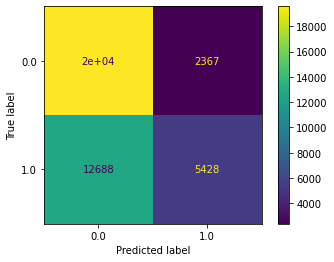

In [6]:
X_num = shots[['FINAL_MARGIN', 'SHOT_NUMBER', 'SHOT_CLOCK', 'TOUCH_TIME',
       'SHOT_DIST', 'CLOSE_DEF_DIST', 'GAME_TIME', 'LOC_X', 'LOC_Y']]

y = np.ravel(shots[['SHOT_MADE_FLAG']])

scaler =  StandardScaler()

scaler.fit(X_num)
X_procc = scaler.transform(X_num)

X_train, X_test, y_train, y_test = train_test_split(X_procc, y, test_size=0.1, stratify=y)

parameters_for_testing = {
    'min_child_weight':[0.0001,0.001,0.01],
    'learning_rate':[0.00001,0.0001,0.001],
    'n_estimators':[1,3,5,10],
    'max_depth':[4, 5]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, scoring='precision')

xgb = gsearch1.fit(X_train, y_train)

print(f"Accuracy score for train data: {xgb.score(X_train, y_train)}")
print(f"Accuracy score for test data: {xgb.score(X_test, y_test)}")

disp_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, xgb.predict(X_test)), display_labels=xgb.classes_)
disp_matrix.plot()
plt.show()

In [7]:
print(xgb.best_params_)

{'learning_rate': 1e-05, 'max_depth': 4, 'min_child_weight': 0.0001, 'n_estimators': 1}


NEURAL NET
Accuracy score for train data: 0.6387495389666753
Accuracy score for test data: 0.6342218229010682


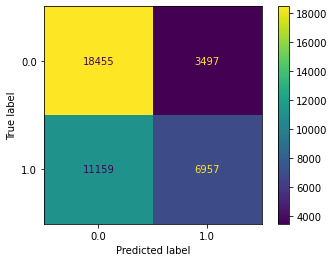

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def train_model(X: pd.DataFrame, y: np.array, model_type=SGDClassifier(), scaler=StandardScaler(), test_size=0.1):
    """
    Function for training different ML methods. You can set different model, scaler, and test size. It prints accuracy scores and plots
    a confusion matrix. 
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)

    if scaler:
        pipe = make_pipeline(scaler, model_type)
    else:
        pipe = make_pipeline(model_type)

    model = pipe.fit(X_train, y_train)

    print(f"Accuracy score for train data: {model.score(X_train, y_train)}")
    print(f"Accuracy score for test data: {model.score(X_test, y_test)}")

    disp_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, model.predict(X_test)), display_labels=model.classes_)
    disp_matrix.plot()
    plt.show()

    return model


print("NEURAL NET")

nn = train_model(X_num, y, MLPClassifier(hidden_layer_sizes=(20, 50, 20)))